<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/6_Linear_twoclass_classification/6_8_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6: Linear two-class classification

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 6.8 Classification Quality Metrics

In this Section we describe simple metrics for judging the quality of a trained two-class classification model, as well as how to make predictions using one.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_6_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/6_Linear_twoclass_classification/chapter_6_datasets
else:
    print('chapter_6_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_6_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/6_Linear_twoclass_classification/chapter_6_library
else:
    print('chapter_6_library already cloned!')

# clone images
if not Path('chapter_6_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/6_Linear_twoclass_classification/chapter_6_images
else:
    print('chapter_6_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_6_library')
sys.path.append('./chapter_6_datasets') 
sys.path.append('./chapter_6_images') 

# import section helper
import section_6_8_helpers

# dataset paths
data_path_1 = 'chapter_6_datasets/3d_classification_data_v0.csv'

# image paths
image_path_1 = 'chapter_6_images/Fig_4_6_new.png'
image_path_2 = 'chapter_6_images/confusion_2class.png'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_6_datasets already cloned!
chapter_6_library already cloned!
chapter_6_images already cloned!


## Making predictions using a trained model

If we denote the optimal set of weights found by minimizing a classification cost function, employing by default label values $y_p \in \left\{-1,+1\right\}$, by $\mathbf{w}^{\star}$ then note we can write our fully tuned linear model as 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}^{\star}\right) =  \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\star}   = w_0^{\star} + x_{1}^{\,}w_1^{\star} + x_{2}^{\,}w_2^{\star} + \cdots + x_{N}^{\,}w_N^{\star}.
\end{equation}

This fully trained model defines an optimal decision boundary for the training dataseet which takes the form

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}^{\star}\right) = 0.
\end{equation}

To predict the label $y$ of an input $\mathbf{x}$ we then process this model through an appropriate step function. Since we by default use label values $y_p \in \left\{-1,+1\right\}$ this step function is conveniently defined by the $\text{sign}\left(\cdot\right)$ function (as detailed in [Section 6.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_3_Softmax.html)), and the predicted label for $\mathbf{x}$ is given as

\begin{equation}
\text{sign}\,\left(\text{model}\left(\mathbf{x},\mathbf{w}^{\star}\right)\right) = y_{\,}.
\end{equation}

This evaluation - which will always take on values $\pm 1$ if $\mathbf{x}$ does not lie *exactly* on the decision boundary (in which case we assign a random value from $\pm 1$) - simply computes which side of the decision boundary the input $\mathbf{x}$ lies on.  If it lies 'above' the decision boundary then $y = +1$, and if 'below' then $y = -1$.  This is illustrated in the figure below.

In [2]:
from IPython.display import HTML
HTML('''<img src="''' + image_path_1 + '''" width="90%" height="auto" alt=""/>''')

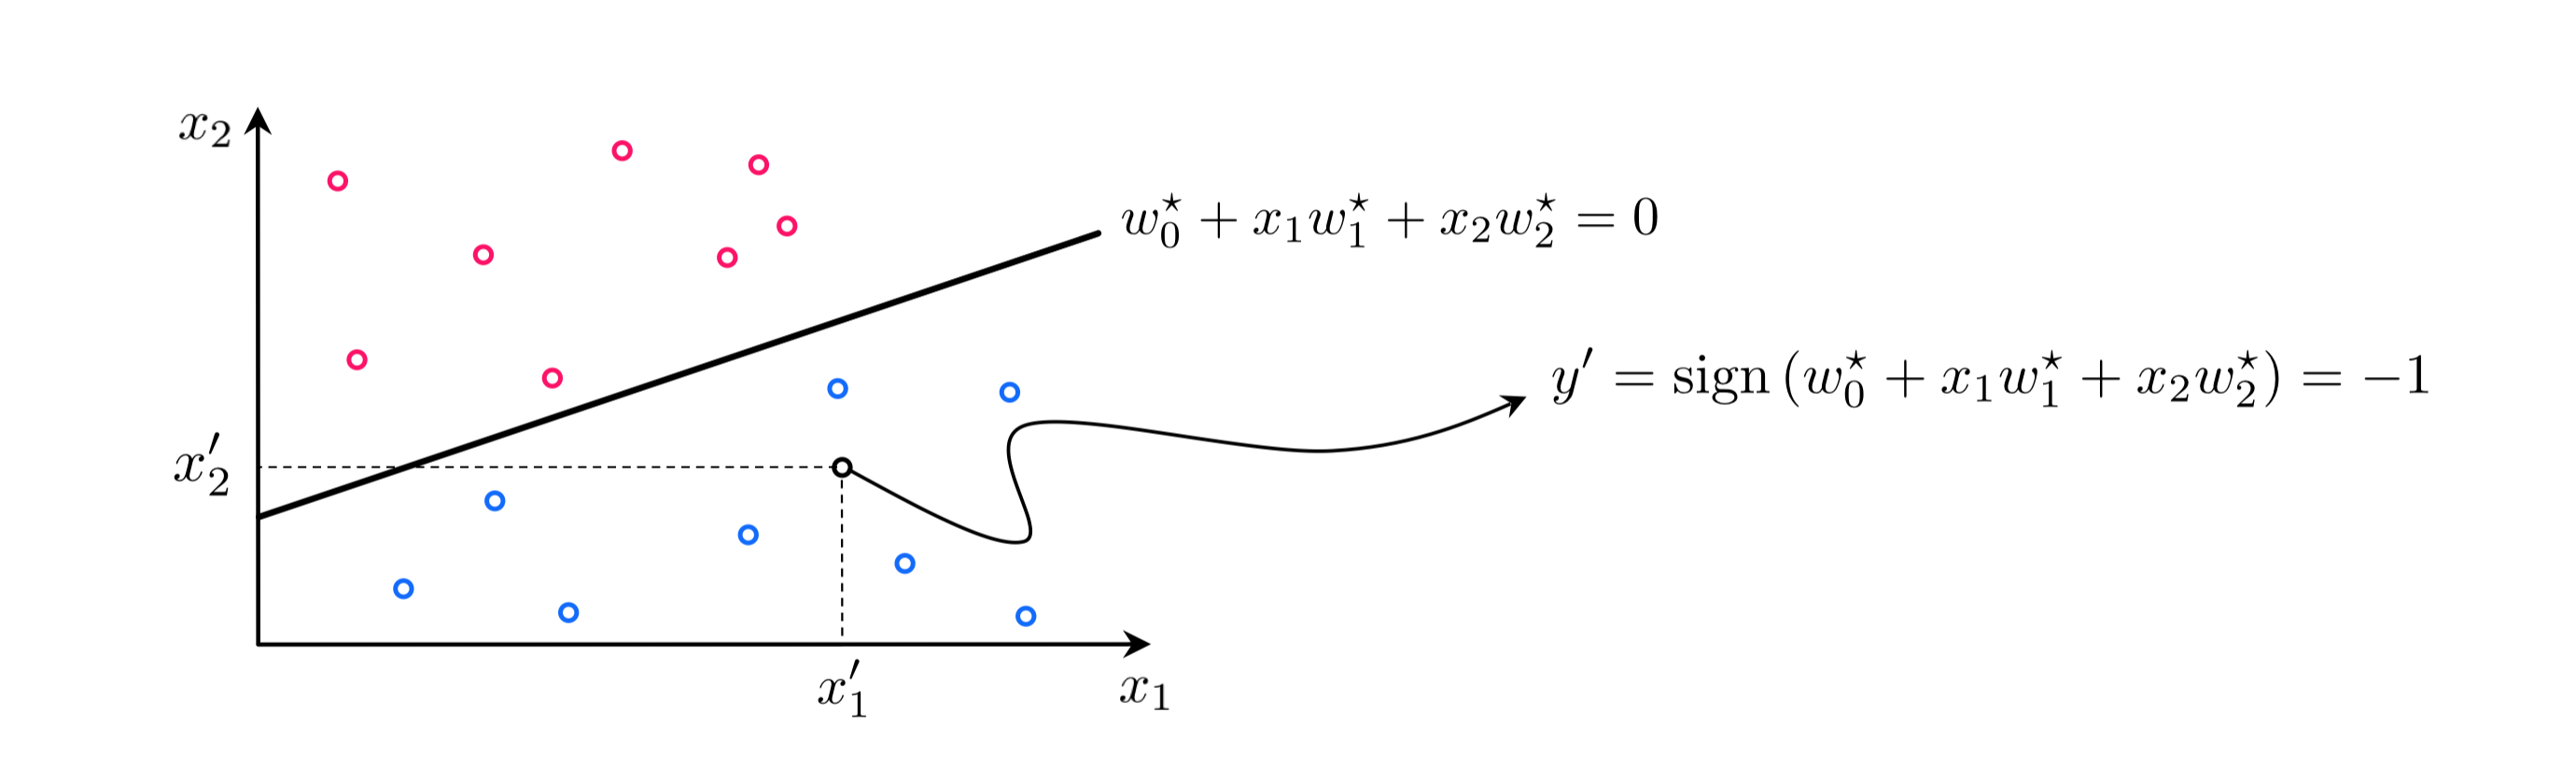

In [3]:
Image(image_path_1, width=900)

<figure>
  <figcaption>   
<strong>Figure 3:</strong> <em> Once a decision boundary has been learned for the training dataset with optimal parameters $w_0^{\star}$ and $\mathbf{w}^{\star}$, the label $y_{\,}$ of a new point $\mathbf{x}_{\,}$ can be predicted by simply checking which side of the boundary it lies on. In the illustration shown here $\mathbf{x}_{\,}$ lies below the learned hyperplane, and as a result is given the label $\textrm{sign}\left(\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\star}\right)=-1$. </em>  </figcaption> 
</figure>

## Confidence scoring

Once a proper decision boundary is learned, we can judge its *confidence* in any point based on *the point's distance to the decision boundary*.  We say that our classifier has *zero* confidence in points lying along the decision boundary itself, because the boundary cannot tell us accurately which class such points belong too (which is why they are randomly assigned a label value if we ever need to make a prediction there).  Likewise we say that *near* the decision boundary we have *little confidence* in the classifier's predictions.  Why is this?  Imagine we apply a small pertibation to the decision boundary, changing its location ever so slightly.  Some points *very close to the original boundary* will end up on the *opposite* side of the new boundary, and will consequently have *different predicted labels*.  Conversely, this is why we have *high confidence* in the predicted labels of points *far* from the decision boundary.  These predicted labels will not change if we make a small change to the location of the decision boundary.

The notion of 'confidence' can be made precise and normalized to be universally applicable by running the point's distance to the boundary through the *sigmoid function* (see  [Section 6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html)).  This gives the confidence that a point belongs to class $+1$.

The signed distance $d$ from a point to the decision boundary provided by our trained model can be computed (see [Section 6.4](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html)) as

\begin{equation}
d =  \frac{b^{\star} + \overset{\,}{\mathbf{x}}_{p}^T\boldsymbol{\omega^{\star}} }{\left\Vert \overset{\,}{\boldsymbol{\omega}^{\star}} \right\Vert_2 }.
\end{equation}

where we denote

\begin{equation}
\text{(bias):}\,\, b^{\star} = w_0^{\star} \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega^{\star}} = 
\begin{bmatrix}
w_1^{\star} \\
w_2^{\star} \\ 
\vdots \\
w_N^{\star}
\end{bmatrix}.
\end{equation}

By evaluating $d$ using the *sigmoid function* 

\begin{equation}
\text{confidence in the predicted label of a point $\mathbf{x}$} \,\,\, =  \sigma\left(d\right)
\end{equation}

we squash it smoothly onto the interval $\left[0,1\right]$.  

When this value equals $0.5$ the point lies on the boundary itself.  If the value is greater than $0.5$ the point lies on the positive side of the decision boundary and so we have larger confidence in its predicted label being $+1$.  When the value is less than $0.5$ the point lies on the *negative* side of the classifier, and so we have less confidence that it truly has label value $+1$.  Because normalization employing the sigmoid squashes $\left(-\infty,+\infty \right)$ down to the interval $\left[0,1 \right]$ this confidence value is often interpreted as a *probability*. 

## Judging the quality of a trained model using *accuracy*

Once we have successfully minimized the a cost function for linear two-class classification it can be a delicate matter to determine our trained model's quality.  The simplest metric for judging the quality of a fully trained model is to simply *count the number of misclassifications* it forms over our training dataset.  This is a raw count of the number of training datapoints $\mathbf{x}_p$ whose true label $y_p$ is predicted *incorrectly* by our trained model.  

To compare the point $\mathbf{x}_p$'s predicted label $\hat{y}_p = \text{sign}\,\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}^{\star}\right)\right)$ and true true label $y_p$ we can use an identity function $\mathcal{I}\left(\cdot\right)$ and compute

\begin{equation}
\mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right) = 
\begin{cases}
0 \,\,\,\,\,\text{if} \,\, \hat{y}_p,= \overset{\,}{y}_p \\
1 \,\,\,\,\,\text{if} \,\,  \hat{y}_p,\neq \overset{\,}{y}_p. \\
\end{cases}
\end{equation}

Summing all $P$ points gives the total number of misclassifications of our trained model


\begin{equation}
\text{number of misclassifications} = \sum_{p=1}^P \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{equation}

Using this we can also compute the *accuracy*  - denoted $\mathcal{A}$ - of a trained model.  This is simply the percentage of training dataset whose labels are correctly predicted by the model.

\begin{equation}
\mathcal{A}= 1 - \frac{1}{P}\sum_{p=1}^P \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{equation}

The accuracy ranges from 0 (no points are classified correctly) to 1 (all points are classified correctly).  

#### <span style="color:#a50e3e;">Example 1: </span> Comparing the Softmax to the number of misclassifications during runs of gradient descent

Our classification cost functions are - in the end - based on smooth approximations to a discrete step function.  This is the function we trully wish to use, i.e., the function through which we truly want to tune the parameters of our model.  However since we cannot easily optimize this step function - as discussed in Sections [6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html) and [6.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_3_Softmax.html) - we settle for a smooth approximation.  The consequences of this practical choice are seen when we compare the cost function history from a run of gradient descent to the corresponding misclassification count measured at each step of the run.  We show such a comparison using  the dataset from Example 1 of [Section 6.4](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html).  In fact we show such results of three independent runs of gradient descent, with the history of misclassifications shown in the left panel and corresponding Softmax cost histories show in the right panel.  Each run is color-coded to distinguish it from the other runs.

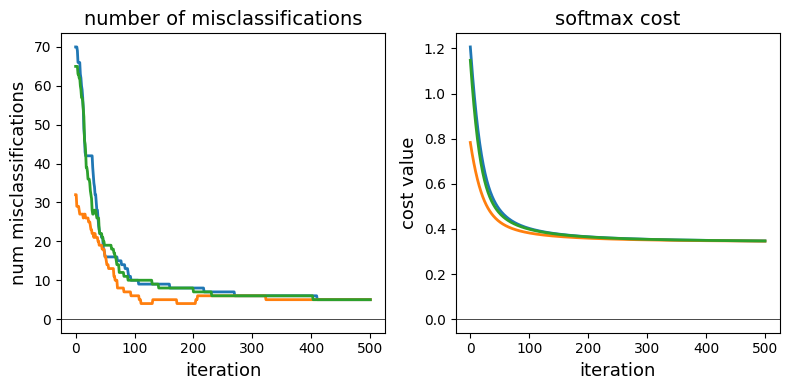

In [4]:
# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')

# create instance of cost comparison demo
demo = section_6_8_helpers.visualizer(data)

# run 
demo.compare_to_counting(cost = 'softmax',max_its = 500,num_runs = 3,alpha = 10**(-1))

Comparing the left and right panels we can see that the number of misclassifications and Softmax evaluations at each step of a gradient descent run do not perfectly track one another.  That is, it is not the case that just because the cost function value is decreasing that so too is the number of misclassifications. Again, this occurs because our Softmax cost is only an approximation of the true quantity we would like to minimize.  

This simple example has an extremely practical implication: after a running a local optimization to minimize a two-class classification cost function the best step, and corresponding weights, are associated with the lowest *number of misclassifications* (or likewise the *highest accuracy*) **not** the lowest cost function value.

## Judging the quality of a trained model using *balanced accuracy*

Classification accuracy is an excellent basic measurement of a trained classifier's performance.  However in certain scenarios using the accuracy metric can paint an incomplete picture of how well we have really solved a classification problem.  For example when a dataset consists of *highly imbalanced classes*  - that is when a dataset has far more examples of one class than the other - the 'accuracy' of a trained model loses its value as a metric.  This is because when one class greatly outnumbers the other in a dataset an accuracy value close to 1 can be misleading: if one class makes up $95\%$ percent of all data points, a naive classifier that blindly assigns the label of the majority class to *every training point* achieves an accuracy of $95\%$.  But here misclassifying $5\%$ amounts to *completely misclassifying an entire class of data*. 

This imaginary scenario points to the main problem with the use of *accuracy* as a proper metric for diagnosing classifier performance on datasets with highly imbalanced classes: because it weights *misclassifications from both classes equally* it fails to convey how well a trained model performs on each class of the data individually.  This results in the potential for strong performance on a very large class of data masking poor performance on a very smaller one.  The simplest way to improve the accuracy metric to take this potential problem into account is, instead of computing accuracy over *both classes together*, to compute accuracy on *each class individually* and combine the resulting metrics.  

If we denote the *indices* of those points with labels $y_p = +1$ and $y_p = -1$ as $\Omega_{+1}$ and $\Omega_{-1}$ respectively, then we can compute the number of misclassifications on each class individually (employing the notation and indicator function introduced above) as 

\begin{equation}
\begin{array}
\
\text{number of misclassifications on $+1$ class} = \sum_{p \in \Omega_{+1}} \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right) \\
\text{number of misclassifications on $-1$ class} = \sum_{p \in \Omega_{-1}} \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{array}
\end{equation}

The accuracy on each class individually can then be likewise computed as (denoting the accuracy on class $+1$ and $-1$ individually as $\mathcal{A}_{+1}$ and $\mathcal{A}_{-1}$ respectively)

\begin{equation}
\begin{array}
\
\mathcal{A}_{+1} = 1 - \frac{1}{\left\vert \Omega_{+1}\right\vert}\sum_{p \in \Omega_{+1}} \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right) \\
\mathcal{A}_{-1}= 1 - \frac{1}{\left\vert \Omega_{-1}\right\vert}\sum_{p \in \Omega_{-1}} \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right) 
\end{array}
\end{equation}

Note here the $\left\vert \Omega_{+1}\right\vert$ and $\left\vert \Omega_{-1}\right\vert$ denote the number of points belonging to the $+1$ and $-1$ class respectively.  We can then combine these two metrics into a single value by *taking their average*.  This combined metric is called *balanced accuracy* (which we denote as $\mathcal{A}_{\text{balanced}}$)

\begin{equation}
\mathcal{A}_{\text{balanced}} = \frac{\mathcal{A}_{+1} + \mathcal{A}_{-1}}{2}.
\end{equation}

Notice that if we return to our motivating scenario above - where we imagined a highly imbalanced dataset with $95\%$ membership in one class and $5\%$ in the other and have simply classified the entire space as the majority class to achieve a $95\%$ accuracy metric - we can capture the fact that one class has been completely misclassified with the individual class accuracy measurements above.  e.g., suppose that the $+1$ class is the majority then while the *overall accuracy* is $\mathcal{A} = 95\%$, the accuracy on each class individually is $\mathcal{A}_{+1} = 1$ and $\mathcal{A}_{-1} = 0$ respectively.  These metrics accurately reflect the fact that the naive classifier correctly classifies the entire $+1$ class, but incorrectly classifies the entire $-1$ class.  Their average - the balanced accuracy metric - also captures this fact since it then takes on the value $\mathcal{A}_{\text{balanced}} = 0.5$.  

The balanced accuracy metric ranges from $0$ to $1$.  When equal to $0$ no point is classified correctly, and when both classes are classified perfectly $\mathcal{A}_{\text{balanced}} = 1$.  Note: if both classes are classified equally well the balanced accuracy reduces to the overall accuracy value $\mathcal{A}$.  Values of the metric in between $0$ and $1$ measure how well - on average - eaach class is classified individually: e.g., as we have seen $\mathcal{A}_{\text{balanced}} = 0.5$ can occur one class is completely misclassified while the other is classified perfectly.  Balanced accuracy is a simple metric for helping us understand whether our learned model has 'behaved poorly' on highly imbalanced datasets.  In order to *improve the behavior* of our learned model in such instances we have to adjust the way we perform two class classification.  One popular way of doing this - called weighted classification - is discussed in the next Section.

##  The confusion matrix and additional quality metrics

Additional metrics for judging the quality of a trained model for two class classification can be formed using the *confusion matrix*, shown figuratively in the illustration below.  A confusion matrix is a simple lookup table where classification results are broken down by actual (across rows) and predicted (across columns) class membership. Here we denote $A$ is the number of data points whose actual label, +1, is identical to the label assigned to them by the trained classifier. The other diagonal entry $D$ is similarly defined as the number of data points whose predicted class, -1, is equal to their actual class. The off-diagonal entries denoted by $B$ and $C$ represent the two types of classification errors wherein the actual and predicted labels do not match one another.  In practice we want these two values to be as small as possible.

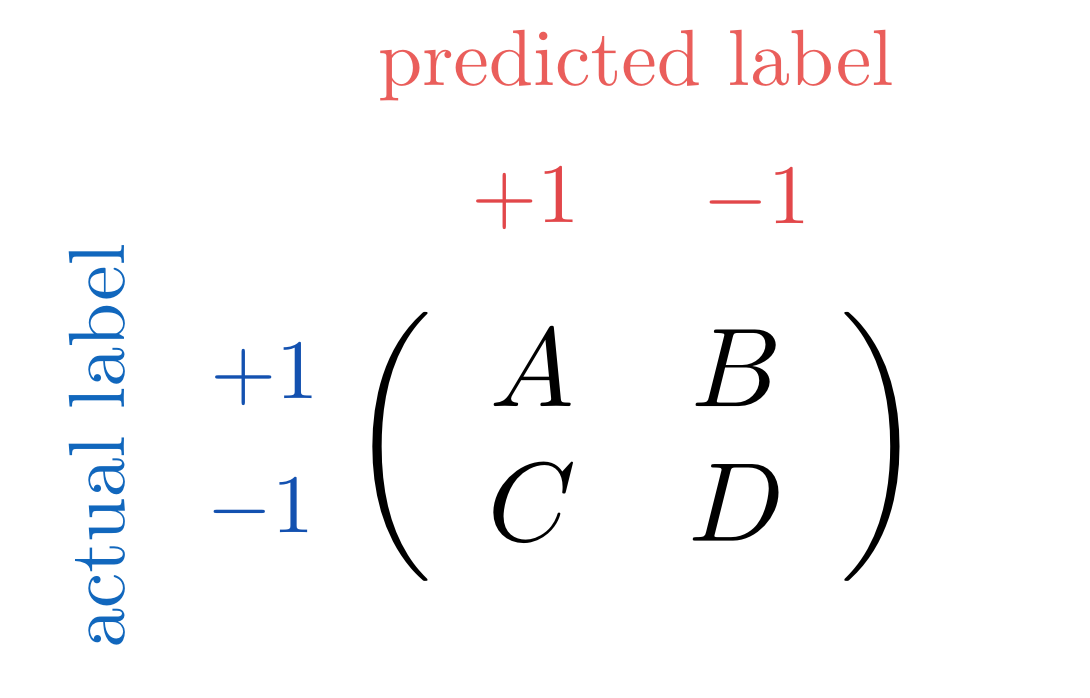

In [5]:
Image(image_path_2, width=200)

<figure>
  <figcaption>   
<strong>Figure 2:</strong> <em> A generic *confusion matrix* as a metric for classification quality.</em>  </figcaption> 
</figure>

Our *accuracy* metric can be expressed in terms of the confusion matrix quantities as

\begin{equation}
\mathcal{A}=\frac{A+D}{A+B+C+D},
\end{equation}

and our accuracy on each individual class likewise as 

\begin{equation}
\begin{array}
\
\mathcal{A}_{+1} = \frac{A}{A + C} \\
\mathcal{A}_{-1}= \frac{D}{B + D}.
\end{array}
\end{equation}

In the jargon of machinee learning these individual accuracy metrics are often called *precision* and *specificity* respectively.  The *balanced accuracy* metric can likewise be expressed as 

\begin{equation}
\mathcal{A}_{\text{balanced}} = \frac{1}{2}\frac{A}{A + C} + \frac{1}{2}\frac{D}{B + D}.
\end{equation}